# Assignment 4: Linear Regression

For this assignment, you may `numpy`, `pandas`, and packages from the Python standard library.

List your team members (name, matriculation number, course of study) in the following cell:


## Team Members
- Likhit Jain, 3678905, M.Sc. Computer Science
- Tareq Abu El Komboz, 3405686, M.Sc. Informatik 
- Serge Kotchourko, 3309449, M.Sc. Informatik

## Task 2: Regression for Time-Series Prediction

Make sure the provided `lake.dat` file is in the same directory as the Jupyter notebook.

You can find the original data including references here: [DaISy - Data of a simulation of the western basin of Lake Erie](https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html).

In [152]:
import matplotlib.pyplot as plt
import numpy as np

In [153]:
def load_lake_data():
    with open('lake.dat') as f:
        data = np.loadtxt(f)
    X = data[:, 6:11]
    Y = data[:, 23:25]
    return X, Y

def train_test_split(X, Y, train_fraction):
    cutoff_idx = int(train_fraction * X.shape[0])
    X_train, Y_train = X[:cutoff_idx], Y[:cutoff_idx]
    X_test, Y_test = X[cutoff_idx:], Y[cutoff_idx:]

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = train_test_split(*load_lake_data(), train_fraction=0.7)
print(f'Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')

Train samples: 39, Test samples: 18


Training data is stored in `X_train` and `Y_train`. Test data is stored in `X_test` and `Y_test`.

1\) Create a plot that shows all inputs and outputs of the training dataset over time. For each variable a separate subplot should be created. Time should be displayed along the x-axis, while the value of each variable should be displayed along the y-axis.

*Hint:* Use `plt.subplots(n, sharex=True)` to create `n` plots that are synchronized along the x-axis.

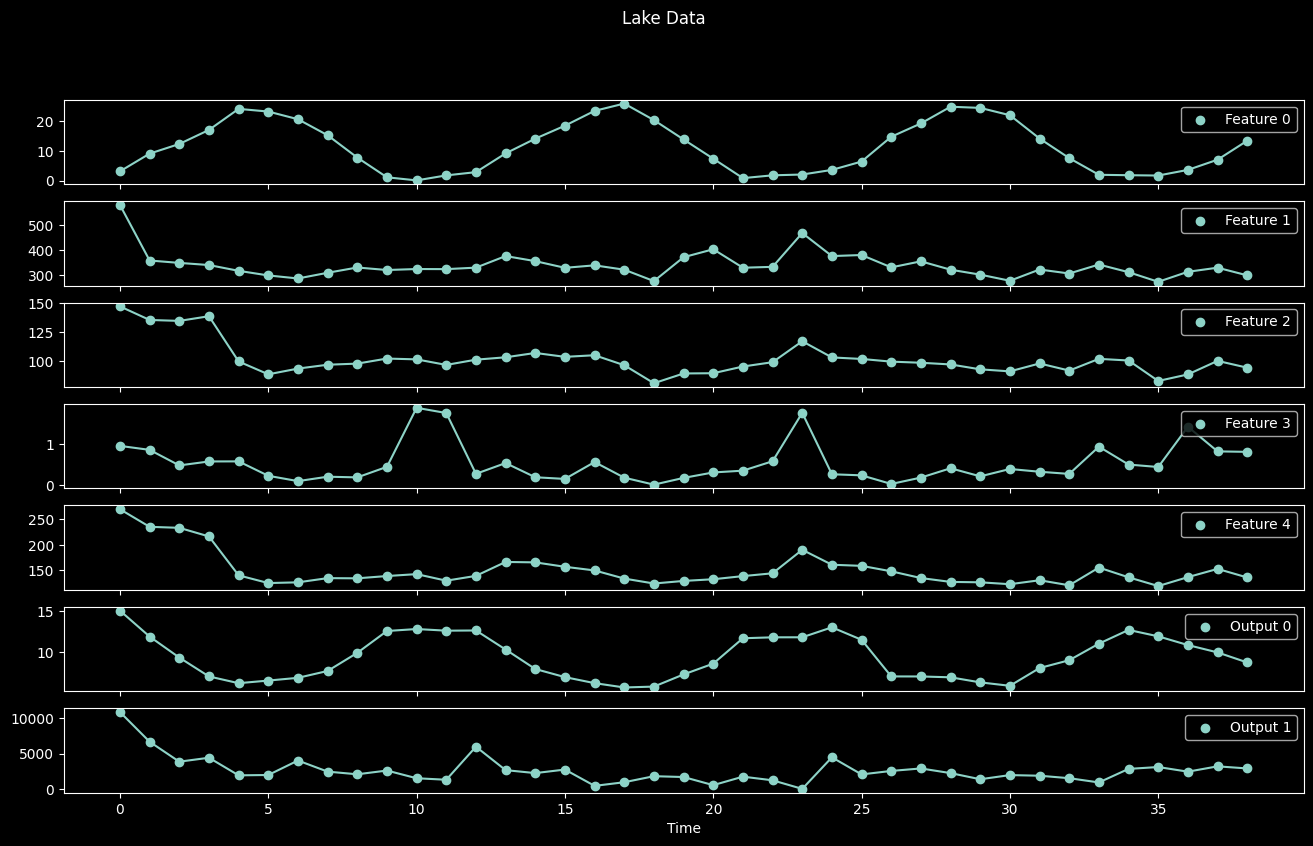

In [172]:
with plt.style.context('dark_background'):
    # create subplot axes
    fig, axes = plt.subplots(7, sharex=True, figsize=(16, 9))

    # plot each feature from the training set on its own subplot, where x-axis is time and y-axis is the feature value
    for i in range(5):
        axes[i].scatter(x=range(X_train.shape[0]), y=X_train[:, i], label=f'Feature {i}')
        axes[i].plot(X_train[:, i])
        axes[i].legend(loc='upper right')

    axes[-2].scatter(x=range(Y_train.shape[0]), y=Y_train[:, 0], label='Output 0')
    axes[-2].plot(Y_train[:, 0])
    axes[-2].legend(loc='upper right')

    axes[-1].scatter(x=range(Y_train.shape[0]), y=Y_train[:, 1], label='Output 1')
    axes[-1].plot(Y_train[:, 1])
    axes[-1].legend(loc='upper right')

    # set the x-axis label
    axes[-1].set_xlabel('Time')

    # set the title
    fig.suptitle('Lake Data')

    # display the plot
    plt.show()


2\) The `make_features` takes as input a matrix of inputs `X` and a matrix of outputs `Y`, as well as the arguments `feature_type` and `lag`.
It computes a features used as input for a linear regression.


`X` has the shape `(T, 5)` and `Y` has the shape `(T, 2)` where `T` is a number of time steps.
`feature_type` is a string with either value `lin` or `quad` whether only linear features or also quadratic features should be computed. `lag` is a boolean that determines whether the lag variables for `t-1`should be included.


If `lag` is False, the returned feature matrix has shape `(T, D)` where `D` depends on the choice of `feature_type`.
For `feature_type=lin` and `lag=False`, `D` equals `5+2+1`, for `feature_type=lin` and `lag=True`, `D` equals `2*(5+2)+1`.
If `lag` is True, the returned feature matrix has shape `(T-1, D)`, since the additional lag variable prevents the creation of a feature for time step $t=0$.


Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`) for both `lag=False` and `lag=True`.


In [155]:
def quadratic_features(X):
    '''
    Given a matrix of features X, return a matrix of quadratic features,
    i.e. a matrix, where each row is multiplied by itself element-wise,
    
    Example:
    X = [[1, 2],
         [3, 4]]
    quadratic_features(X) = [[1, 2, 4],
                                [9, 12, 16]]

    X = [[1, 2, 3],
         [4, 5, 6]]
    quadratic_features(X) = [[1, 2, 3, 4, 6, 9],
                                [16, 20, 24, 25, 30, 36]]
    '''
    A = np.zeros((X.shape[0], X.shape[1] * (X.shape[1] + 1) // 2))
    for i in range(X.shape[0]):
        A[i] = [X[i][j] * X[i][k] for j in range(X.shape[1]) for k in range(j, X.shape[1])]
    return A

def make_features(X, Y, feature_type='lin', lag=False):
    if feature_type == 'lin':
        if lag:
            Phi = np.hstack((
                np.ones((X.shape[0]-1, 1)), # bias/intercept term
                X[1:], # x_t
                X[:-1], # x_{t-1}
                Y[1:], # y_t
                Y[:-1] # y_{t-1}
            ))
        else:
            Phi = np.hstack((
                np.ones((X.shape[0], 1)), # bias/intercept term
                X, # x_t
                Y # y_t
            ))
    elif feature_type == 'quad':
        # Your code here
        if lag:
            Phi = np.hstack((
                np.ones((X.shape[0]-1, 1)), # bias/intercept term
                X[1:], # x_t
                X[:-1], # x_{t-1}
                Y[1:], # y_t
                Y[:-1], # y_{t-1}
                quadratic_features(np.concatenate((X[1:], Y[1:], X[:-1], Y[:-1]), axis=1)) # x_t^2, y_t^2, x_t*y_t, x_{t-1}^2, y_{t-1}^2, x_{t-1}*y_{t-1}, x_t*x_{t-1}, y_t*y_{t-1}, x_t*y_{t-1}, x_{t-1}*y_t

            ))
        else:
            Phi = np.hstack((
                np.ones((X.shape[0], 1)), # bias/intercept term
                X, # x_t
                Y, # y_t
                quadratic_features(np.concatenate((X, Y), axis=1)) # x_t^2, y_t^2, x_t*y_t
            ))
    else:
        raise ValueError(f'feature_type is not implemented for {feature_type}')

    return Phi


## Additional

We added some tests to check our implementation of `make_features`.

In [156]:
print(f'X_train shape: {X_train.shape} \n Y_train shape: {Y_train.shape}')
print(f'X_train:\n{X_train[:5]} \n Y_train:\n{Y_train[:5]}')

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
qa = quadratic_features(a)
print(f'a:\n{a}\nqa:\n{qa}')

X_train shape: (39, 5) 
 Y_train shape: (39, 2)
X_train:
[[3.1145e+00 5.8163e+02 1.4701e+02 9.5210e-01 2.6958e+02]
 [9.0367e+00 3.5832e+02 1.3538e+02 8.5518e-01 2.3520e+02]
 [1.2261e+01 3.4871e+02 1.3458e+02 4.7440e-01 2.3327e+02]
 [1.6955e+01 3.4008e+02 1.3859e+02 5.7118e-01 2.1643e+02]
 [2.3995e+01 3.1678e+02 9.9816e+01 5.7336e-01 1.4049e+02]] 
 Y_train:
[[1.5103e+01 1.0820e+04]
 [1.1908e+01 6.6498e+03]
 [9.3272e+00 3.8519e+03]
 [7.0040e+00 4.4064e+03]
 [6.1731e+00 1.9356e+03]]
a:
[[1 2 3]
 [4 5 6]
 [7 8 9]]
qa:
[[ 1.  2.  3.  4.  6.  9.]
 [16. 20. 24. 25. 30. 36.]
 [49. 56. 63. 64. 72. 81.]]


In [157]:
# Exampe execution with above data, lin features, no lag
Phi = make_features(X_train, Y_train, feature_type='lin', lag=False)
print("'make_features' function output for linear features without lag:")
print(f'Phi shape: {Phi.shape}')
print(f'Phi:\n{Phi[:5]}')

'make_features' function output for linear features without lag:
Phi shape: (39, 8)
Phi:
[[1.0000e+00 3.1145e+00 5.8163e+02 1.4701e+02 9.5210e-01 2.6958e+02
  1.5103e+01 1.0820e+04]
 [1.0000e+00 9.0367e+00 3.5832e+02 1.3538e+02 8.5518e-01 2.3520e+02
  1.1908e+01 6.6498e+03]
 [1.0000e+00 1.2261e+01 3.4871e+02 1.3458e+02 4.7440e-01 2.3327e+02
  9.3272e+00 3.8519e+03]
 [1.0000e+00 1.6955e+01 3.4008e+02 1.3859e+02 5.7118e-01 2.1643e+02
  7.0040e+00 4.4064e+03]
 [1.0000e+00 2.3995e+01 3.1678e+02 9.9816e+01 5.7336e-01 1.4049e+02
  6.1731e+00 1.9356e+03]]


In [158]:

# Exampe execution with above data, lin features, lag
Phi = make_features(X_train, Y_train, feature_type='lin', lag=True)
print("'make_features' function output for linear features with lag:")
print(f'Phi shape: {Phi.shape}')
print(f'Phi:\n{Phi[:5]}')


'make_features' function output for linear features with lag:
Phi shape: (38, 15)
Phi:
[[1.0000e+00 9.0367e+00 3.5832e+02 1.3538e+02 8.5518e-01 2.3520e+02
  3.1145e+00 5.8163e+02 1.4701e+02 9.5210e-01 2.6958e+02 1.1908e+01
  6.6498e+03 1.5103e+01 1.0820e+04]
 [1.0000e+00 1.2261e+01 3.4871e+02 1.3458e+02 4.7440e-01 2.3327e+02
  9.0367e+00 3.5832e+02 1.3538e+02 8.5518e-01 2.3520e+02 9.3272e+00
  3.8519e+03 1.1908e+01 6.6498e+03]
 [1.0000e+00 1.6955e+01 3.4008e+02 1.3859e+02 5.7118e-01 2.1643e+02
  1.2261e+01 3.4871e+02 1.3458e+02 4.7440e-01 2.3327e+02 7.0040e+00
  4.4064e+03 9.3272e+00 3.8519e+03]
 [1.0000e+00 2.3995e+01 3.1678e+02 9.9816e+01 5.7336e-01 1.4049e+02
  1.6955e+01 3.4008e+02 1.3859e+02 5.7118e-01 2.1643e+02 6.1731e+00
  1.9356e+03 7.0040e+00 4.4064e+03]
 [1.0000e+00 2.3104e+01 2.9823e+02 8.8809e+01 2.2017e-01 1.2541e+02
  2.3995e+01 3.1678e+02 9.9816e+01 5.7336e-01 1.4049e+02 6.4963e+00
  1.9822e+03 6.1731e+00 1.9356e+03]]


In [159]:

# Exampe execution with above data, quad features, no lag
Phi = make_features(X_train, Y_train, feature_type='quad', lag=False)
print("'make_features' function output for quadratic features without lag:")
print(f'Phi shape: {Phi.shape}')
print(f'Phi:\n{Phi[:5]}')


'make_features' function output for quadratic features without lag:
Phi shape: (39, 36)
Phi:
[[1.00000000e+00 3.11450000e+00 5.81630000e+02 1.47010000e+02
  9.52100000e-01 2.69580000e+02 1.51030000e+01 1.08200000e+04
  9.70011025e+00 1.81148663e+03 4.57862645e+02 2.96531545e+00
  8.39606910e+02 4.70382935e+01 3.36988900e+04 3.38293457e+05
  8.55054263e+04 5.53769923e+02 1.56795815e+05 8.78435789e+03
  6.29323660e+06 2.16119401e+04 1.39968221e+02 3.96309558e+04
  2.22029203e+03 1.59064820e+06 9.06494410e-01 2.56667118e+02
  1.43795663e+01 1.03017220e+04 7.26733764e+04 4.07146674e+03
  2.91685560e+06 2.28100609e+02 1.63414460e+05 1.17072400e+08]
 [1.00000000e+00 9.03670000e+00 3.58320000e+02 1.35380000e+02
  8.55180000e-01 2.35200000e+02 1.19080000e+01 6.64980000e+03
  8.16619469e+01 3.23803034e+03 1.22338845e+03 7.72800511e+00
  2.12543184e+03 1.07609024e+02 6.00922477e+04 1.28393222e+05
  4.85093616e+04 3.06428098e+02 8.42768640e+04 4.26687456e+03
  2.38275634e+06 1.83277444e+04 1.1577

In [160]:

# Exampe execution with above data, quad features, with lag
Phi = make_features(X_train, Y_train, feature_type='quad', lag=True)
print("'make_features' function output for quadratic features with lag:")
print(f'Phi shape: {Phi.shape}')
print(f'Phi:\n{Phi[:5]}')


'make_features' function output for quadratic features with lag:
Phi shape: (38, 120)
Phi:
[[1.00000000e+00 9.03670000e+00 3.58320000e+02 1.35380000e+02
  8.55180000e-01 2.35200000e+02 3.11450000e+00 5.81630000e+02
  1.47010000e+02 9.52100000e-01 2.69580000e+02 1.19080000e+01
  6.64980000e+03 1.51030000e+01 1.08200000e+04 8.16619469e+01
  3.23803034e+03 1.22338845e+03 7.72800511e+00 2.12543184e+03
  1.07609024e+02 6.00922477e+04 2.81448022e+01 5.25601582e+03
  1.32848527e+03 8.60384207e+00 2.43611359e+03 1.36481280e+02
  9.77770940e+04 1.28393222e+05 4.85093616e+04 3.06428098e+02
  8.42768640e+04 4.26687456e+03 2.38275634e+06 1.11598764e+03
  2.08409662e+05 5.26766232e+04 3.41156472e+02 9.65959056e+04
  5.41170696e+03 3.87702240e+06 1.83277444e+04 1.15774268e+02
  3.18413760e+04 1.61210504e+03 9.00249924e+05 4.21641010e+02
  7.87410694e+04 1.99022138e+04 1.28895298e+02 3.64957404e+04
  2.04464414e+03 1.46481160e+06 7.31332832e-01 2.01138336e+02
  1.01834834e+01 5.68677596e+03 2.6634581